# Alzheimer's Disease prediction

The dataset has been obtained out of the ADNI (Alzheimer's Disease Neuroimaging Initiative) datasets. 
During the course of Alzheimer's disease, people that are first cognitively normal (Label : CN) start having mild cognitive impairments (Label : MCI) before the conversion to Alzheimer's disease (Label : AD).

The dataset is said to be "longitudinal" because patient there are multiple visits per patients which results in multiple rows per patients.

### Columns : 

- "DXCHANGE" : diagnosis of the patient at the corresponding visits. 1 corresponds to  CN, 2 is MCI and 3 is AD.
- "RID" and "PTID" correspond to two different identification number for each patient. As some patients have been seen multiple times, there are represented by multiple lines in the dataset
- "VISCODE" corresponds to the visit number. The first one is "bl" (standing for _baseline_) while the other are encoded as "m#" where "#" is an number that corresponds to the number of month after the baseline. For instance, "m36" means that the visit occured 36 months after the baseline.
- "EXAMDATE" corresponds to the date at the examination.
- "AGE" corresponds to the age AT BASELINE. The age at any visit can be computed from the AGE at baseline and EXAMDATEs
- Some cofactors : 'PTGENDER' -> the gender, 'PTEDUCAT'-> Number of education in years, 'PTMARRY' -> Marital status. 'APOE' -> number of the APOE-epsilon4 genetic mutations which is related to Alzheimer's disease.
- Some cognitive tests : 'CDRSB', 'ADAS11', 'ADAS13', 'MMSE', 'RAVLT_immediate', 'RAVLT_learning', 'RAVLT_forgetting', 'RAVLT_perc_forgetting', 'FAQ', 'MOCA'.
- Some imaging variables : 'Ventricles', 'Hippocampus', 'WholeBrain', 'Entorhinal', 'Fusiform', 'MidTemp', 'ICV' where 'ICV' is the total brain volume.
- Radioactive tracers : 'FDG', 'PIB', 'AV45'

The previous columns are predominantly used by the community. There are way more columns in the dataset that you are free to investigate.

NB: There are missing values.


### Tasks

This notebook offers different tasks to tackle - it is not required to do them all, nor to do them in order. It is simply intended to check your abilities in different settings, from conventional Machine Learning to developping your own ideas. It is clearly prefered to have one task well completed rather than exploring different without significant conclusions.

### Remarks

While exploring and experimenting, you might need to dig into the data. If so, do not hesitate to let your experiments and comment them for the sake of clarity, so that we better understand what you are doing and how you are doing it.


### Evaluation

There are no rigid evaluation of your work, but we will inevitably look at :
- your performance on the different tasks, how you obtained your best performance and potentially the comparison between different techniques
- the consistency and correctness of the method and evaluation techniques you use
- your coding experience
- your ability to explain what you are doing
- the conclusions you draw from the different tasks
- your ability to explore and propose your own ideas.


### Minor comments 

We prefer library as pandas, numpy and scikit-learn to start with as they provide numerous functions and tools to do the job, but you are free to use other Python package.

# Part 1: Alzheimer's Disease (AD) Versus Cognitively  Normal (CN) at baseline

The first task of this notebook consists in keeping only the first visit of each patient ("VISCODE" == "bl") and keeping only cognitively normal patient and patient with Alzheimer's disease ("DXCHANGE" == 1 and "DXCHANGE" == 3).

From this subset of the initial dataset, the goal is to diagnose the patient status (1 or 3) given the other variables (you are free to choose the one you want).

In [1]:
from datetime import datetime
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.experimental import enable_iterative_imputer  
from sklearn.impute import IterativeImputer
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, cross_validate, KFold, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, \
classification_report
from sklearn.neighbors import KNeighborsClassifier

from helpers.my_one_hot_encoder import MyOneHotEncoder

SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 15

plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=BIGGER_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE+2)  # fontsize of the figure title

np.random.seed(1000)

trainval_ratio = 0.80
test_ratio = 0.20

In [2]:
data = pd.read_csv('data_small.csv')

C:\Users\pjsudharshan\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (47,48,473,475,476,489,490,491,492,493,494,495,496,497,498,499,500,501) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
headers = data.columns.values
print(headers)

['Unnamed: 0' 'Unnamed: 0.1' 'RID' 'PTID' 'VISCODE' 'SITE' 'D1' 'D2'
 'COLPROT' 'ORIGPROT' 'EXAMDATE' 'DX_bl' 'DXCHANGE' 'AGE' 'PTGENDER'
 'PTEDUCAT' 'PTETHCAT' 'PTRACCAT' 'PTMARRY' 'APOE4' 'FDG' 'PIB' 'AV45'
 'CDRSB' 'ADAS11' 'ADAS13' 'MMSE' 'RAVLT_immediate' 'RAVLT_learning'
 'RAVLT_forgetting' 'RAVLT_perc_forgetting' 'FAQ' 'MOCA' 'EcogPtMem'
 'EcogPtLang' 'EcogPtVisspat' 'EcogPtPlan' 'EcogPtOrgan' 'EcogPtDivatt'
 'EcogPtTotal' 'EcogSPMem' 'EcogSPLang' 'EcogSPVisspat' 'EcogSPPlan'
 'EcogSPOrgan' 'EcogSPDivatt' 'EcogSPTotal' 'FLDSTRENG' 'FSVERSION'
 'Ventricles' 'Hippocampus' 'WholeBrain' 'Entorhinal' 'Fusiform' 'MidTemp'
 'ICV' 'DX' 'EXAMDATE_bl' 'CDRSB_bl' 'ADAS11_bl' 'ADAS13_bl' 'MMSE_bl'
 'RAVLT_immediate_bl' 'RAVLT_learning_bl' 'RAVLT_forgetting_bl'
 'RAVLT_perc_forgetting_bl' 'FAQ_bl' 'FLDSTRENG_bl' 'FSVERSION_bl'
 'Ventricles_bl' 'Hippocampus_bl' 'WholeBrain_bl' 'Entorhinal_bl'
 'Fusiform_bl' 'MidTemp_bl' 'ICV_bl' 'MOCA_bl' 'EcogPtMem_bl'
 'EcogPtLang_bl' 'EcogPtVisspat_bl' 'Ec

In [4]:
data.tail()

,Unnamed: 0,Unnamed: 0.1,RID,PTID,VISCODE,SITE,D1,D2,COLPROT,ORIGPROT,...,ST102TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST102TS_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST103CV_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST103SA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST103TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST103TS_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST104CV_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST104SA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST104TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST104TS_UCSFFSX_11_02_15_UCSFFSX51_08_01_16
8315,12726,12726,1023,036_S_1023,m108,36,1,1,ADNI2,ADNI1,...,,,,,,,,,,
8316,12730,12730,296,100_S_0296,m120,100,1,1,ADNI2,ADNI1,...,,,,,,,,,,
8317,12731,12731,1286,100_S_1286,m108,100,1,1,ADNI2,ADNI1,...,,,,,,,,,,
8318,12733,12733,2061,035_S_2061,m72,35,1,1,ADNI2,ADNIGO,...,,,,,,,,,,
8319,12734,12734,4556,100_S_4556,m48,100,1,1,ADNI2,ADNI2,...,,,,,,,,,,


In [5]:
data.drop(columns=['Unnamed: 0','Unnamed: 0.1'], inplace=True)

In [6]:
data.tail()

,RID,PTID,VISCODE,SITE,D1,D2,COLPROT,ORIGPROT,EXAMDATE,DX_bl,...,ST102TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST102TS_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST103CV_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST103SA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST103TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST103TS_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST104CV_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST104SA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST104TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST104TS_UCSFFSX_11_02_15_UCSFFSX51_08_01_16
8315,1023,036_S_1023,m108,36,1,1,ADNI2,ADNI1,2017-01-10,CN,...,,,,,,,,,,
8316,296,100_S_0296,m120,100,1,1,ADNI2,ADNI1,2017-01-24,LMCI,...,,,,,,,,,,
8317,1286,100_S_1286,m108,100,1,1,ADNI2,ADNI1,2017-01-25,CN,...,,,,,,,,,,
8318,2061,035_S_2061,m72,35,1,1,ADNI2,ADNIGO,2016-09-14,EMCI,...,,,,,,,,,,
8319,4556,100_S_4556,m48,100,1,1,ADNI2,ADNI2,2017-01-30,EMCI,...,,,,,,,,,,


In [7]:
# Transforming 'VISCODE' to meaningful numeric data (VIS).

data['VIS'] = [0 if vis=="bl" else vis[1:] for vis in data['VISCODE']]
data['VIS'] = pd.to_numeric(data['VIS'])
data.VIS.head()

0     0
1     0
2     6
3    12
4    24
Name: VIS, dtype: int64

In [8]:
# Filtering the needed subset for prediction.

datap1 = data.query('VISCODE == "bl" and (DXCHANGE == 1 or DXCHANGE == 3)')
datap1.drop(columns=['VISCODE'], inplace=True)
datap1.DXCHANGE.value_counts()
# The labels are fairly imbalanced, so lets use F1 score to judge the classifier.

C:\Users\pjsudharshan\Anaconda3\lib\site-packages\pandas\core\frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


1.0    521
3.0    336
Name: DXCHANGE, dtype: int64

In [9]:
# Checking the number of null values in each of the columns.

null_columns = datap1.columns[datap1.isnull().any()]
datap1[null_columns].isnull().sum()
# There are many columns with missing data. So, let's focus on the features mentioned above to make things easier
# and also try not to remove many rows with missing values.

APOE4                                             3
FDG                                             224
PIB                                             852
AV45                                            426
ADAS11                                            2
                                               ... 
INSULAQC_UCSFFSX_11_02_15_UCSFFSX51_08_01_16      1
OCCQC_UCSFFSX_11_02_15_UCSFFSX51_08_01_16         1
BGQC_UCSFFSX_11_02_15_UCSFFSX51_08_01_16          1
CWMQC_UCSFFSX_11_02_15_UCSFFSX51_08_01_16         1
VENTQC_UCSFFSX_11_02_15_UCSFFSX51_08_01_16        1
Length: 89, dtype: int64

In [10]:
# Checking the number of null values in each of the columns we are interested in.

interested_columns = ['DXCHANGE','RID','PTID','EXAMDATE','AGE','PTGENDER','PTEDUCAT','PTMARRY','APOE4','CDRSB',\
                     'ADAS11','ADAS13','MMSE','RAVLT_immediate','RAVLT_learning','RAVLT_forgetting','RAVLT_perc_forgetting',\
                     'FAQ','MOCA','Ventricles','Hippocampus','WholeBrain','Entorhinal','Fusiform','MidTemp','ICV','FDG','PIB',\
                     'AV45']
datap1[interested_columns].isnull().sum()

DXCHANGE                   0
RID                        0
PTID                       0
EXAMDATE                   0
AGE                        0
PTGENDER                   0
PTEDUCAT                   0
PTMARRY                    0
APOE4                      3
CDRSB                      0
ADAS11                     2
ADAS13                     8
MMSE                       0
RAVLT_immediate            5
RAVLT_learning             5
RAVLT_forgetting           5
RAVLT_perc_forgetting      9
FAQ                        1
MOCA                     425
Ventricles                48
Hippocampus              112
WholeBrain                28
Entorhinal               133
Fusiform                 133
MidTemp                  133
ICV                        7
FDG                      224
PIB                      852
AV45                     426
dtype: int64

In [11]:
# We consider relevant columns for prediction; Also, we extract relevant columns taking into account the number
# of missing data of colums (i.e., discarding the columns with missing values more than 20%).

datap1pred = datap1[['PTGENDER','PTMARRY','AGE','PTEDUCAT','APOE4','CDRSB','ADAS11','ADAS13','MMSE', \
                       'RAVLT_immediate','RAVLT_learning','RAVLT_forgetting','RAVLT_perc_forgetting','FAQ', \
                       'Ventricles','Hippocampus','WholeBrain','Entorhinal','Fusiform','MidTemp','ICV','DXCHANGE']]
datap1pred.reset_index(inplace = True, drop=True)
num_imp = IterativeImputer(max_iter=20).fit_transform(datap1pred.select_dtypes(exclude=[object]))
datap1predi = pd.concat([datap1pred.select_dtypes(include=[object]), pd.DataFrame(num_imp)], axis=1)
datap1predi.columns = datap1pred.columns

C:\Users\pjsudharshan\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


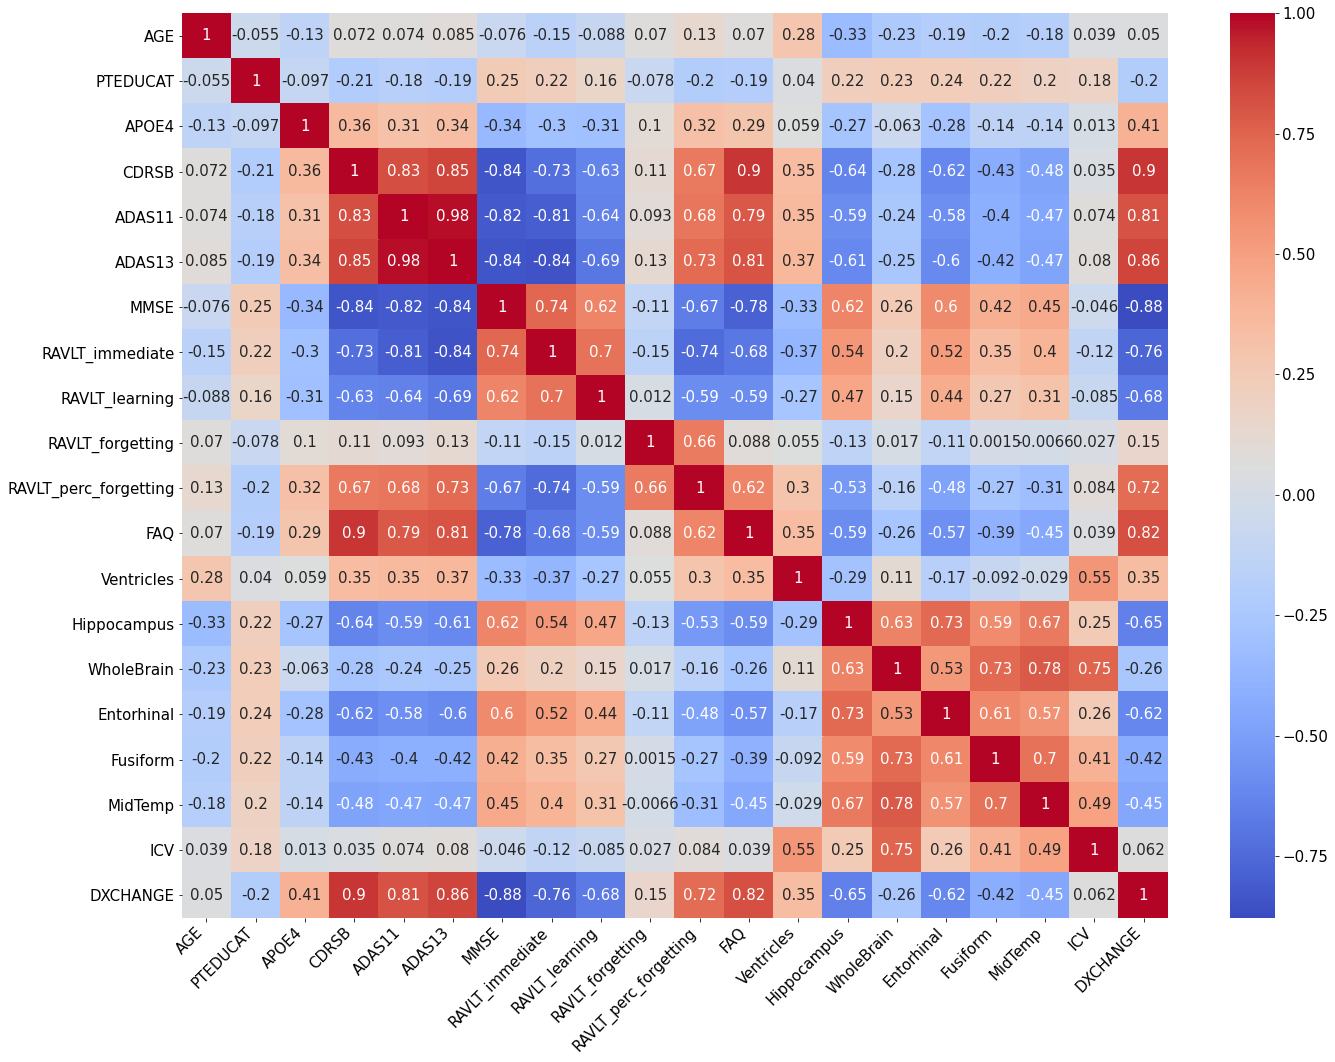

In [12]:
# Finding correlation between the features.

corr = datap1predi.corr()

plt.figure(figsize=(20,15))
ax = sns.heatmap(
    corr,
    cmap="coolwarm",
    annot=True,
    fmt='.2g'
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right',
);
plt.tight_layout()

# There are a few features which you can get rid off as they are correlated to each other. Let's consider the features which has correlation > 0.85.
For instance: We can eliminate FAQ (since correlated to CDRSB), ADAS13 (since correlated to ADAS11) and so on...

But, in our case, as we don't have so many features which might make it computationally heavy for prediction, we will stick to using all the features (not drop any column).

In [13]:
# Do you remember? We imputed the missing values.
# Preserving the information about which values had been missing can be informative. 
# For instance, someone forgot to take a particular medical test or they forgot to arrive on the day of testing. So, we won't be
# having the values for these.

datap1predic = datap1predi.copy()
cols_with_missing = (col for col in datap1pred.columns 
                                 if datap1pred[col].isnull().any())
for col in cols_with_missing:
    datap1predic[col + '_was_missing'] = datap1predic[col].isnull().astype('int64')

In [14]:
# One-Hot encodding for categorical features.

ind = datap1predic.select_dtypes(include=[object]).columns

onehotpt1 = datap1predic
for i in ind:
    onehotpt1 = MyOneHotEncoder().encodePandasColAndMerge(data_frame = onehotpt1, col_name = i)

In [15]:
# Shuffling, Splitting and Standardizing data.

# Shuffle (1st time).
shufdata = onehotpt1.sample(frac=1)
x_data = shufdata[shufdata.columns.difference(['DXCHANGE'])]
y_data = shufdata[['DXCHANGE']]

# Shuffle and stratified to care of class ratios.
# Here, the 'x_train' subset contains the validation set as we would be performing 5-fold cross validation.
x_train, x_test, y_un_train, y_un_test = train_test_split(x_data, y_data, \
                                                    test_size=1 - trainval_ratio, stratify=y_data)

scaler = preprocessing.StandardScaler().fit(x_train)
x_train_sc = scaler.transform(x_train)
x_test_sc = scaler.transform(x_test)

# Using ravel() to flatten the column
y_train = y_un_train.values.ravel()
y_test = y_un_test.values.ravel()

In [16]:
# Logistic Regression - Cross Validation

scoring = {'accuracy' : make_scorer(accuracy_score), 
           'precision' : make_scorer(precision_score),
           'recall' : make_scorer(recall_score), 
           'f1_score' : make_scorer(f1_score)}

logreg = LogisticRegression()
scores_val = cross_validate(logreg, x_train_sc, y_train, cv=5, scoring=scoring)
print("5 fold Logistic Regression F1 Score: {}".format(scores_val['test_f1_score'].mean()))

5 fold Logistic Regression F1 Score: 0.996392756655364


Accuracy of logistic regression classifier on test set: 0.994186

Since the class distribution is unbalanced in the dataset, let us find F1 score to judge the model
F1 Score of logistic regression classifier on test set: 0.995261

Classification Report: 
               precision    recall  f1-score   support

         1.0       0.99      1.00      1.00       105
         3.0       1.00      0.99      0.99        67

    accuracy                           0.99       172
   macro avg       1.00      0.99      0.99       172
weighted avg       0.99      0.99      0.99       172



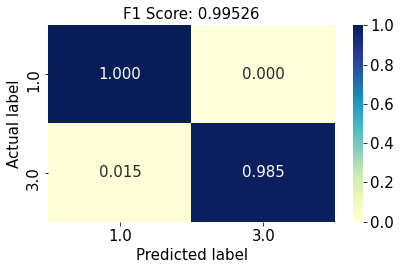

In [17]:
# In the above case, we didn't have any hyperparameter to tune, so we could have directly trained on 'train_val' subset and
# could have tested on 'test' set. But, note that we need this step for K-NN, Neural networks, etc., for hyperparameter 
# optimization.

logreg.fit(x_train_sc, y_train)
y_pred = logreg.predict(x_test_sc)
score_test = logreg.score(x_test_sc, y_test)
print('Accuracy of logistic regression classifier on test set: {:.6f}'.format(score_test),end='\n'*2)
print('Since the class distribution is unbalanced in the dataset, let us find F1 score to judge the model')

f1 = f1_score(y_test, y_pred)
print('F1 Score of logistic regression classifier on test set: {:.6f}'.format(f1))

cm = confusion_matrix(y_test, y_pred)
cr = classification_report(y_test, y_pred)
print("\nClassification Report: \n",cr)

cm_n = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
cmn = pd.DataFrame(cm_n, columns=np.unique(y_test), index = np.unique(y_test))
plt.figure()
sns.heatmap(cmn, annot=True, fmt='.3f', cmap="YlGnBu");
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = ('F1 Score: %.5f' %f1)
plt.tight_layout()
plt.title(all_sample_title, y=1.1);
plt.tight_layout()
plt.savefig('sav_images/p1confusion_matrix_logreg.svg',transparent=True)
plt.show()

Neighbor which gives the best F1 score (through 5 fold CV) = 23
F1 Score of KNN classifier on test set: 0.990566

Classification Report: 
               precision    recall  f1-score   support

         1.0       0.98      1.00      0.99       105
         3.0       1.00      0.97      0.98        67

    accuracy                           0.99       172
   macro avg       0.99      0.99      0.99       172
weighted avg       0.99      0.99      0.99       172



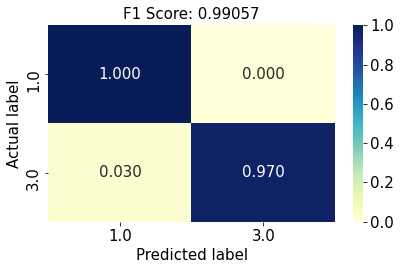

In [18]:
# Let us try KNN Classifier.

knn = KNeighborsClassifier()
krange = np.arange(1, 151)
param_grid_knn = {'n_neighbors': krange}
knn_gscv = GridSearchCV(knn, param_grid_knn, scoring=('f1'), cv=5)
knn_gscv.fit(x_train_sc, y_train)
print("Neighbor which gives the best F1 score (through 5 fold CV) = {}".format(knn_gscv.best_params_['n_neighbors']))

y_pred_knn = knn_gscv.predict(x_test_sc)

f1_knn= f1_score(y_test, y_pred_knn)
print('F1 Score of KNN classifier on test set: {:.6f}'.format(f1_knn))

cm_knn = confusion_matrix(y_test, y_pred_knn)
cr_knn = classification_report(y_test, y_pred_knn)
print("\nClassification Report: \n",cr_knn)

cm_knn_n = cm_knn.astype('float') / cm_knn.sum(axis=1)[:, np.newaxis]
cmn_knn = pd.DataFrame(cm_knn_n, columns=np.unique(y_test), index = np.unique(y_test))
plt.figure()
sns.heatmap(cmn_knn, annot=True, fmt='.3f', cmap="YlGnBu");
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = ('F1 Score: %.5f' %f1_knn)
plt.tight_layout()
plt.title(all_sample_title, y=1.1);
plt.tight_layout()
plt.savefig('sav_images/p1confusion_matrix_knn.svg',transparent=True)
plt.show()

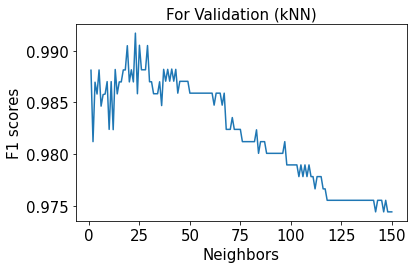

In [19]:
# EXTRAS.
# Interesting graph: Here you can also see how the neighbor were set based on F1 Score.

plt.figure()
plt.ylabel('F1 scores');
plt.xlabel('Neighbors');
all_sample_title = ('For Validation (kNN)')
plt.plot(krange,knn_gscv.cv_results_['mean_test_score'])
plt.tight_layout()
plt.title(all_sample_title, y=1.1);
plt.tight_layout()
plt.savefig('sav_images/p1knn.svg',transparent=True)
plt.show()

Logistic Regression is slightly better than K-NN for this particular task (on this dataset and ) in terms of prediction. But, the difference isn't significant enough to say that one is better than the other for this task.

Also, you can perform WILCOXON TEST and see if can reject the null hypothesis or not based on p-values obtained for Recall, Precision and F-Score. This might be out of the scope for this task.

# Let's skip the neural net as we already have a good classifier. Also, hypermeter tuning for the neural nets are relatively more expensive (due to #of hidden layers, hidden nodes in each layer, activation funtions, batch normalization, dropout probability, etc.)

# Part 2: AD versus CN versus MCI at baseline

The second task of the notebook is similar to the first one except that you add the intermediate status: subjects with Mild Cognitive Impairements (MCI). This is still a diagnosis exercise where you predict the "DXCHANGE" status from the other variables.

In [20]:
# To make things look nicer and easy to interpret, I might use the same variable names as in Part 1 for Part 2.

input("Press Enter to continue...")

# So, cleearing the variables.
%reset -f

Press Enter to continue...


In [21]:
from datetime import datetime
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.experimental import enable_iterative_imputer  
from sklearn.impute import IterativeImputer
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, cross_validate, KFold, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, \
classification_report
from sklearn.neighbors import KNeighborsClassifier

from helpers.my_one_hot_encoder import MyOneHotEncoder

SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 15

plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=BIGGER_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE+2)  # fontsize of the figure title

np.random.seed(1000)

trainval_ratio = 0.80
test_ratio = 0.20

In [22]:
# Skipping explanations for the pre-process steps which has already been explained in Part1.

data = pd.read_csv('data_small.csv')
data.drop(columns=['Unnamed: 0','Unnamed: 0.1'], inplace=True)

data['VIS'] = [0 if vis=="bl" else vis[1:] for vis in data['VISCODE']]
data['VIS'] = pd.to_numeric(data['VIS'])

datap1 = data.query('VISCODE == "bl"')
datap1.drop(columns=['VISCODE'], inplace=True)
datap1.DXCHANGE.value_counts()

C:\Users\pjsudharshan\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (47,48,473,475,476,489,490,491,492,493,494,495,496,497,498,499,500,501) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
C:\Users\pjsudharshan\Anaconda3\lib\site-packages\pandas\core\frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


2.0    864
1.0    521
3.0    336
Name: DXCHANGE, dtype: int64

In [23]:
# Skipping explanations for the pre-process steps which has already been explained in Part1.

interested_columns = ['DXCHANGE','RID','PTID','EXAMDATE','AGE','PTGENDER','PTEDUCAT','PTMARRY','APOE4','CDRSB',\
                     'ADAS11','ADAS13','MMSE','RAVLT_immediate','RAVLT_learning','RAVLT_forgetting','RAVLT_perc_forgetting',\
                     'FAQ','MOCA','Ventricles','Hippocampus','WholeBrain','Entorhinal','Fusiform','MidTemp','ICV','FDG','PIB',\
                     'AV45']
datap1[interested_columns].isnull().sum()

DXCHANGE                    0
RID                         0
PTID                        0
EXAMDATE                    0
AGE                         0
PTGENDER                    0
PTEDUCAT                    0
PTMARRY                     0
APOE4                       6
CDRSB                       0
ADAS11                      3
ADAS13                     12
MMSE                        0
RAVLT_immediate             5
RAVLT_learning              5
RAVLT_forgetting            5
RAVLT_perc_forgetting      10
FAQ                         5
MOCA                      825
Ventricles                 79
Hippocampus               242
WholeBrain                 45
Entorhinal                265
Fusiform                  265
MidTemp                   265
ICV                        13
FDG                       425
PIB                      1701
AV45                      833
dtype: int64

In [24]:
# Skipping explanations for the pre-process steps which has already been explained in Part1.

datap1pred = datap1[['PTGENDER','PTMARRY','AGE','PTEDUCAT','APOE4','CDRSB','ADAS11','ADAS13','MMSE', \
                       'RAVLT_immediate','RAVLT_learning','RAVLT_forgetting','RAVLT_perc_forgetting','FAQ', \
                       'Ventricles','Hippocampus','WholeBrain','Entorhinal','Fusiform','MidTemp','ICV','DXCHANGE']]
datap1pred.reset_index(inplace = True, drop=True)
num_imp = IterativeImputer(max_iter=20).fit_transform(datap1pred.select_dtypes(exclude=[object]))
datap1predi = pd.concat([datap1pred.select_dtypes(include=[object]), pd.DataFrame(num_imp)], axis=1)
datap1predi.columns = datap1pred.columns

C:\Users\pjsudharshan\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


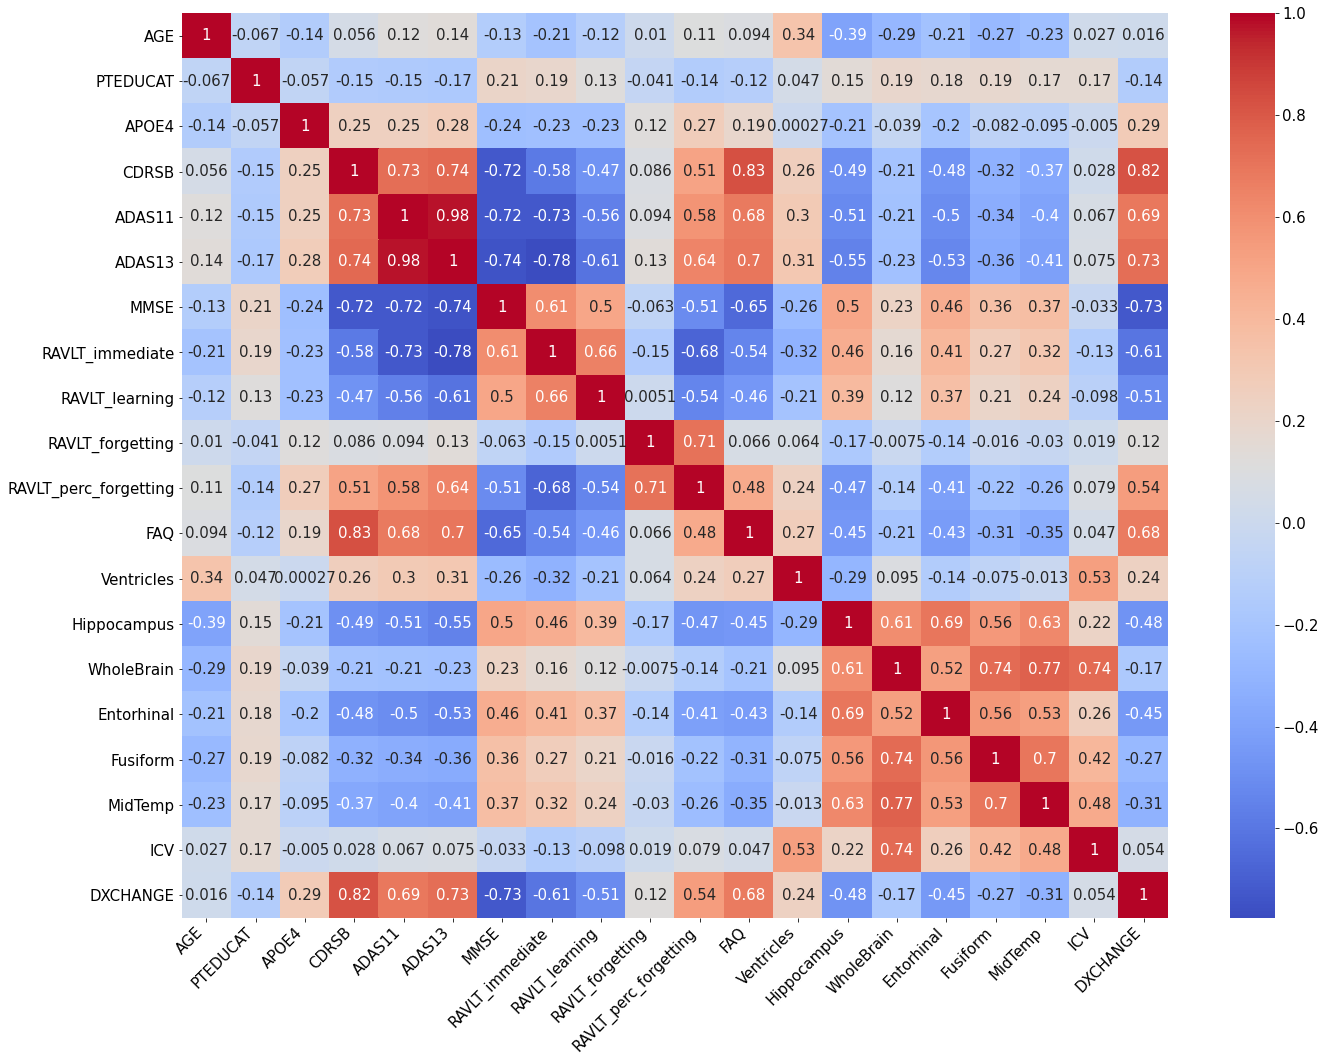

In [25]:
# Finding correlation between the features.

corr = datap1predi.corr()

plt.figure(figsize=(20,15))
ax = sns.heatmap(
    corr,
    cmap="coolwarm",
    annot=True,
    fmt='.2g'
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right',
);
plt.tight_layout()

# There are a few features which you can get rid off as they are correlated to each other. Let's consider the features which has correlation > 0.85.
For instance: We can eliminate FAQ (since correlated to CDRSB), ADAS13 (since correlated to ADAS11) and so on...

But, in our case, as we don't have so many features which might make it computationally heavy for prediction, we will stick to using all the features (not drop any column).

In [26]:
# Skipping explanations for the pre-process steps which has already been explained in Part1.

datap1predic = datap1predi.copy()
cols_with_missing = (col for col in datap1pred.columns 
                                 if datap1pred[col].isnull().any())
for col in cols_with_missing:
    datap1predic[col + '_was_missing'] = datap1predic[col].isnull().astype('int64')

ind = datap1predic.select_dtypes(include=[object]).columns

onehotpt1 = datap1predic
for i in ind:
    onehotpt1 = MyOneHotEncoder().encodePandasColAndMerge(data_frame = onehotpt1, col_name = i)

In [27]:
# Shuffling, Splitting and Standardizing data.

# Shuffle (1st time).
shufdata = onehotpt1.sample(frac=1)
x_data = shufdata[shufdata.columns.difference(['DXCHANGE'])]
y_data = shufdata[['DXCHANGE']]

# Shuffle and stratified to care of class ratios.
# Here, the 'x_train' subset contains the validation set as we would be performing 5-fold cross validation.
x_train, x_test, y_un_train, y_un_test = train_test_split(x_data, y_data, \
                                                    test_size=1 - trainval_ratio, stratify=y_data)

scaler = preprocessing.StandardScaler().fit(x_train)
x_train_sc = scaler.transform(x_train)
x_test_sc = scaler.transform(x_test)

# Using ravel() to flatten the column
y_train = y_un_train.values.ravel()
y_test = y_un_test.values.ravel()

In [28]:
# Logistic Regression - Cross Validation

# Note that we are using micro averaging for this multiclass classification
scoring = {'f1_score' : make_scorer(f1_score, average='micro')}

logreg = LogisticRegression()
scores_val = cross_validate(logreg, x_train_sc, y_train, cv=5, scoring=scoring)
print("5 fold Logistic Regression F1 Score: {}".format(scores_val['test_f1_score'].mean()))

5 fold Logistic Regression F1 Score: 0.9251515151515152


Accuracy of logistic regression classifier on test set: 0.913043

Since the class distribution is different in the dataset, let us find F1 score to judge the model
F1 Score of logistic regression classifier on test set: 0.913043

Classification Report: 
               precision    recall  f1-score   support

         1.0       0.96      0.92      0.94       105
         2.0       0.89      0.94      0.92       173
         3.0       0.90      0.82      0.86        67

    accuracy                           0.91       345
   macro avg       0.92      0.90      0.91       345
weighted avg       0.91      0.91      0.91       345



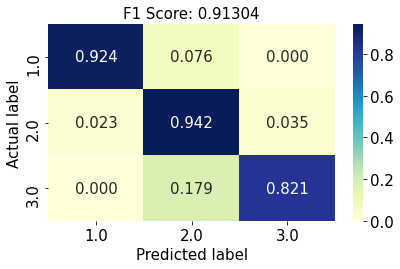

In [29]:
# In the above case, we didn't have any hyperparameter to tune, so we could have directly trained on 'train_val' subset and
# could have tested on 'test' set. But, note that we need this step for K-NN, Neural networks, etc., for hyperparameter 
# optimization.

logreg.fit(x_train_sc, y_train)
y_pred = logreg.predict(x_test_sc)
score_test = logreg.score(x_test_sc, y_test)
print('Accuracy of logistic regression classifier on test set: {:.6f}'.format(score_test),end='\n'*2)
print('Since the class distribution is different in the dataset, let us find F1 score to judge the model')

f1 = f1_score(y_test, y_pred, average='micro')
print('F1 Score of logistic regression classifier on test set: {:.6f}'.format(f1))

cm = confusion_matrix(y_test, y_pred)
cr = classification_report(y_test, y_pred)
print("\nClassification Report: \n",cr)

cm_n = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
cmn = pd.DataFrame(cm_n, columns=np.unique(y_test), index = np.unique(y_test))
plt.figure()
sns.heatmap(cmn, annot=True, fmt='.3f', cmap="YlGnBu");
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = ('F1 Score: %.5f' %f1)
plt.tight_layout()
plt.title(all_sample_title, y=1.1);
plt.tight_layout()
plt.savefig('sav_images/p2confusion_matrix_logreg.svg',transparent=True)
plt.show()

Neighbor which gives the best F1 score (through 5 fold CV) = 43
F1 Score of KNN classifier on test set: 0.733333

Classification Report: 
               precision    recall  f1-score   support

         1.0       0.63      0.84      0.72       105
         2.0       0.75      0.69      0.72       173
         3.0       0.96      0.67      0.79        67

    accuracy                           0.73       345
   macro avg       0.78      0.73      0.74       345
weighted avg       0.76      0.73      0.74       345



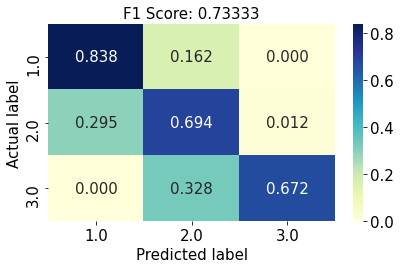

In [30]:
# Let us try KNN Classifier.

knn = KNeighborsClassifier()
krange = np.arange(1, 151)
param_grid_knn = {'n_neighbors': krange}
knn_gscv = GridSearchCV(knn, param_grid_knn, scoring='f1_micro', cv=5)
knn_gscv.fit(x_train_sc, y_train)
print("Neighbor which gives the best F1 score (through 5 fold CV) = {}".format(knn_gscv.best_params_['n_neighbors']))

y_pred_knn = knn_gscv.predict(x_test_sc)

f1_knn= f1_score(y_test, y_pred_knn, average='micro')
print('F1 Score of KNN classifier on test set: {:.6f}'.format(f1_knn))

cm_knn = confusion_matrix(y_test, y_pred_knn)
cr_knn = classification_report(y_test, y_pred_knn)
print("\nClassification Report: \n",cr_knn)

cm_knn_n = cm_knn.astype('float') / cm_knn.sum(axis=1)[:, np.newaxis]
cmn_knn = pd.DataFrame(cm_knn_n, columns=np.unique(y_test), index = np.unique(y_test))
plt.figure()
sns.heatmap(cmn_knn, annot=True, fmt='.3f', cmap="YlGnBu");
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = ('F1 Score: %.5f' %f1_knn)
plt.tight_layout()
plt.title(all_sample_title, y=1.1);
plt.tight_layout()
plt.savefig('sav_images/p2confusion_matrix_knn.svg',transparent=True)
plt.show()

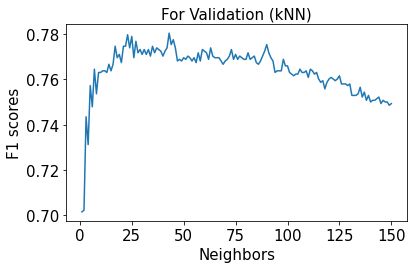

In [31]:
# EXTRAS.
# Interesting graph: Here you can also see how the neighbors were set based on F1 Score.

plt.figure()
plt.ylabel('F1 scores');
plt.xlabel('Neighbors');
all_sample_title = ('For Validation (kNN)')
plt.plot(krange,knn_gscv.cv_results_['mean_test_score'])
plt.tight_layout()
plt.title(all_sample_title, y=1.1);
plt.tight_layout()
plt.savefig('sav_images/p2knn.svg',transparent=True)
plt.show()

Logistic Regression is better than K-NN for this particular task (on this dataset and ) in terms of prediction. Here, the difference is significant enough to say that one is better than the other for this task.

Also you can perform WILCOXON TEST and see if can reject the null hypothesis or not based on p-values obtained for Recall, Precision and F-Score. This might be out of the scope for this task.

# Part 3: AD versus CN versus MCI in 3 years

Here, the task is not to diagnose the status from the other value at the same visit, but to split the individual visits into past and future ones. You will use any variables from the past to predict the status (CN, AD or MCI) of the patients 3 years ahead of time.

Here, you should only consider one visit in the past and predict one status 3 years ahead.

NB: You can reprocude the experiments by choosing other temporal horizons such as 2, 4 or 5 years.

In [32]:
# To make things look nicer and easy to interpret, I might use the same variable names as in Part 1 for Part 2.

input("Press Enter to continue...")

# So, cleearing the variables.
%reset -f

Press Enter to continue...


In [33]:
from datetime import datetime
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.experimental import enable_iterative_imputer  
from sklearn.impute import IterativeImputer
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, cross_validate, KFold, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, \
classification_report
from sklearn.neighbors import KNeighborsClassifier

from helpers.my_one_hot_encoder import MyOneHotEncoder

SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 15

plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=BIGGER_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE+2)  # fontsize of the figure title

np.random.seed(1000)

trainval_ratio = 0.80
test_ratio = 0.20

In [34]:
# Skipping explanations for the pre-process steps which has already been explained in Part1.

data = pd.read_csv('data_small.csv')
data.drop(columns=['Unnamed: 0','Unnamed: 0.1'], inplace=True)

data['VIS'] = [0 if vis=="bl" else vis[1:] for vis in data['VISCODE']]
data['VIS'] = pd.to_numeric(data['VIS'])

datap1 = data.drop(columns=['VISCODE'])
datap1.DXCHANGE.value_counts()

C:\Users\pjsudharshan\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (47,48,473,475,476,489,490,491,492,493,494,495,496,497,498,499,500,501) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


2.0    3924
1.0    2665
3.0    1731
Name: DXCHANGE, dtype: int64

In [35]:
# Checking the number of null values in each of the columns we are interested in.

interested_columns = ['DXCHANGE','RID','PTID','EXAMDATE','AGE','PTGENDER','PTEDUCAT','PTMARRY','APOE4','CDRSB',\
                     'ADAS11','ADAS13','MMSE','RAVLT_immediate','RAVLT_learning','RAVLT_forgetting','RAVLT_perc_forgetting',\
                     'FAQ','MOCA','Ventricles','Hippocampus','WholeBrain','Entorhinal','Fusiform','MidTemp','ICV','FDG','PIB',\
                     'AV45']
datap1[interested_columns].isnull().sum()

DXCHANGE                    0
RID                         0
PTID                        0
EXAMDATE                    0
AGE                         0
PTGENDER                    0
PTEDUCAT                    0
PTMARRY                     0
APOE4                       6
CDRSB                     100
ADAS11                     41
ADAS13                    124
MMSE                       28
RAVLT_immediate           113
RAVLT_learning            113
RAVLT_forgetting          135
RAVLT_perc_forgetting     200
FAQ                        76
MOCA                     3754
Ventricles               1989
Hippocampus              2549
WholeBrain               1793
Entorhinal               2842
Fusiform                 2842
MidTemp                  2842
ICV                      1571
FDG                      5153
PIB                      8120
AV45                     6359
dtype: int64

In [36]:
# Sort values based on RID and then VIS

datap1.sort_values(["RID", "VIS"], axis=0, ascending=True, inplace=True)

In [37]:
# Skipping explanations for the pre-process steps which has already been explained in Part1.

datap1pred = datap1[['PTGENDER','PTMARRY','VIS','AGE','PTEDUCAT','APOE4','CDRSB','ADAS11','ADAS13','MMSE', \
                       'RAVLT_immediate','RAVLT_learning','RAVLT_forgetting','RAVLT_perc_forgetting','FAQ', \
                       'Ventricles','Hippocampus','WholeBrain','Entorhinal','Fusiform','MidTemp','ICV','DXCHANGE']]
datap1pred.reset_index(inplace = True, drop=True)
num_imp = IterativeImputer(max_iter=20).fit_transform(datap1pred.select_dtypes(exclude=[object]))
datap1predi = pd.concat([datap1pred.select_dtypes(include=[object]), pd.DataFrame(num_imp)], axis=1)
datap1predi.columns = datap1pred.columns

C:\Users\pjsudharshan\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


In [38]:
# Skipping explanations for the pre-process steps which has already been explained in Part1.

datap1predic = datap1predi.copy()
cols_with_missing = (col for col in datap1pred.columns 
                                 if datap1pred[col].isnull().any())
for col in cols_with_missing:
    datap1predic[col + '_was_missing'] = datap1pred[col].isnull().astype('int64')

ind = datap1predic.select_dtypes(include=[object]).columns

onehotpt1 = datap1predic
for i in ind:
    onehotpt1 = MyOneHotEncoder().encodePandasColAndMerge(data_frame = onehotpt1, col_name = i)

In [39]:
# It has been told to consider only one past visit. Here, we consider the _baseline_(bl) as the past visit.
# We can also randomly choose the past visit, but we may not be having the data for 3rd year from that visit if the randomly
# chosen visit is 12 or 24 months from the baseline.

# For this case, we can use non-sequence methods or sequencing methods like LSTMs, HMMs, etc.
# Since, we know that the number of past histories we consider is just one for this case, let's stick to non-sequence methods

newdata = pd.DataFrame() 
# filtering and concatenating the data with the condition that we have 3rd year data from the baseline for a particular patient.
flag = 0
def filter1(s):
    for row in s.itertuples():
        if row[1] == 0:
            flag = 1
            index_b = row[0]
        if flag == 1 and row[1] == 36:
            flag = 0
            yield [index_b,row[0]]

cat1 = np.array(list(zip(*filter1(onehotpt1)))[0]).ravel()
cat2 = np.array(list(zip(*filter1(onehotpt1)))[1]).ravel()

past = onehotpt1.loc[cat1].reset_index(drop=True)
future = onehotpt1.loc[cat2].reset_index(drop=True)

# Concatenating previous X(features) and Y (label) with new X(features).
newdata = pd.concat([past, future], axis=1)

# Renaming the duplicates.
cols = pd.Series(newdata.columns)
for dup in cols[cols.duplicated()].unique(): 
    cols[cols[cols == dup].index.values.tolist()] = [dup + '.' + str(i) if i != 0 else dup for i in range(sum(cols == dup))]

newdata.columns = cols
print(newdata.shape)

(727, 86)


In [40]:
# Shuffling, Splitting and Standardizing data.

# Shuffle (1st time).
shufdata = newdata.sample(frac=1)
x_data = shufdata[shufdata.columns.difference(['DXCHANGE.1'])]
y_data = shufdata['DXCHANGE.1']

# Shuffle and stratified to care of class ratios.
# Here, the 'x_train' subset contains the validation set as we would be performing 5-fold cross validation.
x_train, x_test, y_un_train, y_un_test = train_test_split(x_data, y_data, \
                                                    test_size=1 - trainval_ratio, stratify=y_data)

scaler = preprocessing.StandardScaler().fit(x_train)
x_train_sc = scaler.transform(x_train)
x_test_sc = scaler.transform(x_test)

# Using ravel() to flatten the column
y_train = y_un_train.values.ravel()
y_test = y_un_test.values.ravel()

In [41]:
# Logistic Regression - Cross Validation

# Note that we are using micro averaging for this multiclass classification
scoring = {'f1_score' : make_scorer(f1_score, average='micro')}

logreg = LogisticRegression()
scores_val = cross_validate(logreg, x_train_sc, y_train, cv=5, scoring=scoring)
print("5 fold Logistic Regression F1 Score: {}".format(scores_val['test_f1_score'].mean()))

5 fold Logistic Regression F1 Score: 0.8554229295608607


Accuracy of logistic regression classifier on test set: 0.856164

Since the class distribution is different in the dataset, let us find F1 score to judge the model
F1 Score of logistic regression classifier on test set: 0.856164

Classification Report: 
               precision    recall  f1-score   support

         1.0       0.90      0.86      0.88        44
         2.0       0.88      0.85      0.86        74
         3.0       0.75      0.86      0.80        28

    accuracy                           0.86       146
   macro avg       0.84      0.86      0.85       146
weighted avg       0.86      0.86      0.86       146



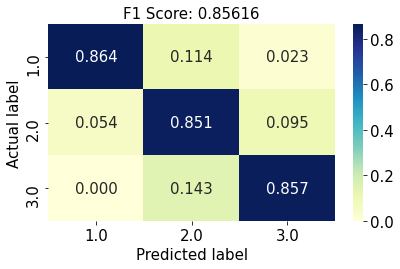

In [42]:
# In the above case, we didn't have any hyperparameter to tune, so we could have directly trained on 'train_val' subset and
# could have tested on 'test' set. But, note that we need this step for K-NN, Neural networks, etc., for hyperparameter 
# optimization.

logreg.fit(x_train_sc, y_train)
y_pred = logreg.predict(x_test_sc)
score_test = logreg.score(x_test_sc, y_test)
print('Accuracy of logistic regression classifier on test set: {:.6f}'.format(score_test),end='\n'*2)
print('Since the class distribution is different in the dataset, let us find F1 score to judge the model')

f1 = f1_score(y_test, y_pred, average='micro')
print('F1 Score of logistic regression classifier on test set: {:.6f}'.format(f1))

cm = confusion_matrix(y_test, y_pred)
cr = classification_report(y_test, y_pred)
print("\nClassification Report: \n",cr)

cm_n = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
cmn = pd.DataFrame(cm_n, columns=np.unique(y_test), index = np.unique(y_test))
plt.figure()
sns.heatmap(cmn, annot=True, fmt='.3f', cmap="YlGnBu");
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = ('F1 Score: %.5f' %f1)
plt.tight_layout()
plt.title(all_sample_title, y=1.1);
plt.tight_layout()
plt.savefig('sav_images/p3confusion_matrix_logreg.svg',transparent=True)
plt.show()

Neighbor which gives the best F1 score (through 5 fold CV) = 28
F1 Score of KNN classifier on test set: 0.794521

Classification Report: 
               precision    recall  f1-score   support

         1.0       0.86      0.73      0.79        44
         2.0       0.75      0.89      0.81        74
         3.0       0.86      0.64      0.73        28

    accuracy                           0.79       146
   macro avg       0.82      0.75      0.78       146
weighted avg       0.81      0.79      0.79       146



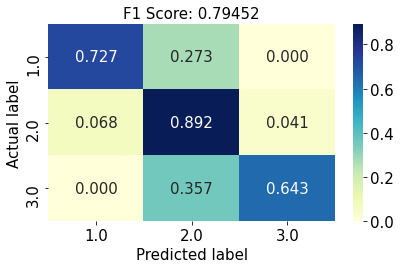

In [43]:
# Let us try KNN Classifier.

knn = KNeighborsClassifier()
krange = np.arange(1, 151)
param_grid_knn = {'n_neighbors': krange}
knn_gscv = GridSearchCV(knn, param_grid_knn, scoring='f1_micro', cv=5)
knn_gscv.fit(x_train_sc, y_train)
print("Neighbor which gives the best F1 score (through 5 fold CV) = {}".format(knn_gscv.best_params_['n_neighbors']))

y_pred_knn = knn_gscv.predict(x_test_sc)

f1_knn= f1_score(y_test, y_pred_knn, average='micro')
print('F1 Score of KNN classifier on test set: {:.6f}'.format(f1_knn))

cm_knn = confusion_matrix(y_test, y_pred_knn)
cr_knn = classification_report(y_test, y_pred_knn)
print("\nClassification Report: \n",cr_knn)

cm_knn_n = cm_knn.astype('float') / cm_knn.sum(axis=1)[:, np.newaxis]
cmn_knn = pd.DataFrame(cm_knn_n, columns=np.unique(y_test), index = np.unique(y_test))
plt.figure()
sns.heatmap(cmn_knn, annot=True, fmt='.3f', cmap="YlGnBu");
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = ('F1 Score: %.5f' %f1_knn)
plt.tight_layout()
plt.title(all_sample_title, y=1.1);
plt.tight_layout()
plt.savefig('sav_images/p3confusion_matrix_knn.svg',transparent=True)
plt.show()

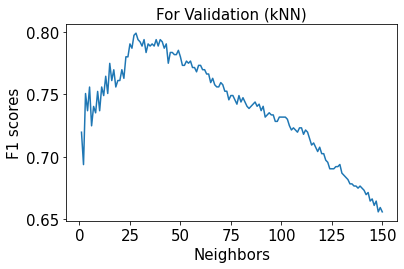

In [44]:
# EXTRAS.
# Interesting graph: Here you can also see how F1 was set based on the neighbors.

plt.figure()
plt.ylabel('F1 scores');
plt.xlabel('Neighbors');
all_sample_title = ('For Validation (kNN)')
plt.plot(krange,knn_gscv.cv_results_['mean_test_score'])
plt.tight_layout()
plt.title(all_sample_title, y=1.1);
plt.tight_layout()
plt.savefig('sav_images/p2knn.svg',transparent=True)
plt.show()

Logistic Regression is better than K-NN for this particular task (on this dataset and ) in terms of prediction. Here, the difference is significant enough to say that one is better than the other for this task.

Also you can perform WILCOXON TEST and see if can reject the null hypothesis or not based on p-values obtained for Recall, Precision and F-Score. This might be out of the scope for this task.

# Part 4: AD versus CN versus MCI in 3 years, with longitudinal data

This part is relatively similar to the precedent, except that instead of using only one visit in the past to predict the diagnosis in 3 years, you are welcome to used longitudinal measurements per individual, therefore use all the past visits of the individual to predict the diagnosis outcome in 3 years.

NB: You can reproduce the experiments by choosing other temporal horizons such as 2, 4 or 5 years.

**I haven't had time to implement this due to my pressed schedule lately. If you are interested to see the solution, I can find some time in the next or next to next week for implementing this.**


**<br>But, here is my solution. 
Initially, I will concatenate just like in Part-3 (Refer Part 3 concatenation).<br>
I would use a typical 1-D Convolutional architecture.<br>
First, a 1D convolutional layer as the first layer, then avg-pooling followed by another convolution layer and then Adaptive Avg Pooling (Refer below link to know about adaptive pooling) followed by fully connected layer and then a softmax layer ->now you have the probabilities of the class.<br>
<br>
Adaptive Avg Pooling is used here so that you can tackle the problem of different input sizes. In this case, we have the patient data where the number of visit is different for each patients. So, concatenating visits for each patient will give us different length of input data.
<br>**

https://pytorch.org/cppdocs/api/function_namespacetorch_1_1nn_1_1functional_1a49cdf5fcca79bf985616e734f8d898ce.html)

In addition to above, you can also use a modified LSTM for this case.